# Networking graph analysis among twitter users 

Twitter users usually interact through replies, retweets, and quoted tweets. These interactions between the users are used for inferring the influential users and for community detection.  

### Table of Contents

* 1\. [Creating interactions graph](#cell1)
* 2\. [Influential users using PageRank algorithm](#cell2)
    * 2.1. [Visualizing the interactions graph](#cell21)
* 3\. [Community detection using Louvain algorithm](#cell3)
    * 3.1. [Visualizing communities](#cell31)

In [1]:
import collections as col

import numpy as np
import pandas as pd

# visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import iplot, plot
import matplotlib.cm as cm

# graph analysis
import networkx as nx
import community as community_louvain

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = '../data/'

##### Loading the processed Singapore-based data 

In [4]:
tweets = pd.read_csv(DATA_PATH + "sg.csv")
tweets.shape

(181423, 54)

## 1. Creating interactions graph  <a id="cell1"></a>
##### A directed weighted graph of interactions - replies, retweets, and quoted tweets between the users. 
##### The weights denote the number of interactions between two users.

### Creating directed graph with nodes, edges and weights 

Graph: Users' interaction through replies, retweets and quotes
- Nodes: Username
- Edge: From a user replying/retweeting/quoting to the author of the replied/retweeted/quoted tweet
- Weight: Number of interactions between any two users 

In [5]:
def get_all_interacting_users():
    sg_users = set() 
    retweeted_users = set()
    quoted_users = set()
    replied_users = set()

    for u in tweets['user_screenname_x']: # merged csvs created user_screenname_x and user_screenname_y
        sg_users.add(u)
    print("Count unique SG users: ", len(sg_users))

    for u in tweets[tweets['replied_to_user_screenname'].notna()]['replied_to_user_screenname']: 
        if u == u:  replied_users.add(u)
    print("Count unique replied users: ", len(replied_users))

    for u in tweets[tweets['retweeted_user_screenname'].notna()]['retweeted_user_screenname']: 
        if u == u: retweeted_users.add(u)
    print("Count unique retweeted users: ", len(retweeted_users))

    for u in tweets[tweets['quoted_user_screenname'].notna()]['quoted_user_screenname']: 
        if u == u:  quoted_users.add(u)
    print("Count unique quoted users: ", len(quoted_users))
    
    common_interacting_users = set.intersection(sg_users, replied_users, retweeted_users, quoted_users)
    print("{} total unique common interacting users".format(len(common_interacting_users)))
    
    return set.union(sg_users, replied_users, retweeted_users, quoted_users)


def get_weighted_interacting_edges():
    interacting_edges = dict() # try set as well

    # replies interaction
    replies_sg = tweets[tweets['tweet_enagagement_type'] == 'Reply'][['user_screenname_x', 'replied_to_user_screenname']]
    for user, iuser in zip(replies_sg['user_screenname_x'], replies_sg['replied_to_user_screenname']):
        if user and iuser and (user != iuser): 
            if (user, iuser,) in interacting_edges:
                interacting_edges[(user, iuser,)] += 1
            else:
                interacting_edges[(user, iuser,)] = 1

    # retweets interaction
    retweets_sg = tweets[tweets['tweet_enagagement_type'] == 'Retweet'][['user_screenname_x', 'retweeted_user_screenname']]
    for user, iuser in zip(retweets_sg['user_screenname_x'], retweets_sg['retweeted_user_screenname']):
        if user and iuser and (user != iuser):  
            if (user, iuser,) in interacting_edges:
                interacting_edges[(user, iuser,)] += 1
            else:
                interacting_edges[(user, iuser,)] = 1

    # quotes interaction
    quotes_sg = tweets[tweets['tweet_enagagement_type'] == 'Quote'][['user_screenname_x', 'quoted_user_screenname']]
    for user, iuser in zip(quotes_sg['user_screenname_x'], quotes_sg['quoted_user_screenname']):
        if user and iuser and (user != iuser):  
            if (user, iuser,) in interacting_edges:
                interacting_edges[(user, iuser,)] += 1
            else:
                interacting_edges[(user, iuser,)] = 1

    weighted_interacting_edges_ = set()
    for k, v in interacting_edges.items():
        weighted_interacting_edges_.add(k + (v,))
        
    return weighted_interacting_edges_

def create_weighted_directed_graph(nodes, edges):
    G = nx.MultiDiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    return G

def graph_details(G):
    degrees = [val for (node, val) in G.degree()]
    print("The maximum degree of the graph is " + str(np.max(degrees))) 
    print("The minimum degree of the graph is " + str(np.min(degrees)))
    print("There are " + str(G.number_of_nodes()) + " nodes and " + str(G.number_of_edges()) + " edges present in the graph")
    print("The average degree of the nodes in the graph is " + str(np.mean(degrees)))

In [6]:
all_interacting_users = get_all_interacting_users()
print("{} total unique interacting users".format(len(all_interacting_users)))
weighted_interacting_edges = get_weighted_interacting_edges()

Count unique SG users:  22531
Count unique replied users:  10458
Count unique retweeted users:  16999
Count unique quoted users:  7647
273 total unique common interacting users
49459 total unique interacting users


In [7]:
G = create_weighted_directed_graph(all_interacting_users, weighted_interacting_edges)
graph_details(G)

The maximum degree of the graph is 1350
The minimum degree of the graph is 0
There are 49460 nodes and 72608 edges present in the graph
The average degree of the nodes in the graph is 2.936029114435908


## 2. Influential users using PageRank algorithm <a id="cell2"></a>
#### Applied PageRanking on interactions graph to get the top 50 users

In [8]:
def get_top_ranked_users(G, top_users_count=50):
    ranked_users = nx.pagerank(G, 0.9)
    ranked_users = dict(sorted(ranked_users.items(), key=lambda item: item[1], reverse=True))
    
    return list(ranked_users)[:top_users_count]

##### Top influential users 

In [9]:
top_ranking = get_top_ranked_users(G)
top_ranking[:10]

['ChannelNewsAsia',
 'MothershipSG',
 'straits_times',
 'TODAYonline',
 'STForeignDesk',
 'JustinOngTODAY',
 'leehsienloong',
 'VP',
 'MatthewMohanCNA',
 'CherylLinCNA']

#### Quality check of the ranking algorithm

The number of verified users in the top X rankings as the quality check of the ranking algo.


In [10]:
def quality_check_pagerank(top_ranking, top_x=50):
    sg_verified_users =  tweets[tweets['user_verified'] == True]['user_screenname_x']
    rt_verified_users = tweets[(tweets['tweet_enagagement_type'] == 'Retweet') & (tweets['retweeted_user_verified'] == True)]['retweeted_user_screenname']
    q_verified_users = tweets[(tweets['tweet_enagagement_type'] == 'Quote') & (tweets['quoted_user_verified'] == True)]['quoted_user_screenname']    

    all_verified_users = set(list(sg_verified_users) + list(rt_verified_users) + list(q_verified_users))
    z = set(top_ranking).intersection(all_verified_users)
    print("The number of verified users in the top {} rankings - {}%".format( top_x, len(z)/top_x*100))
    return len(z)/top_x*100
    

In [11]:
quality_check_pagerank(top_ranking)

The number of verified users in the top 50 rankings - 70.0%


70.0

In [12]:
def generate_dash_influential_users(top_ranking, influential_users_save_path):
    # TODO: Can add followers counts but missing for retweeted_user_screenname and quoted_user_screenname
    normal_users = tweets[tweets['user_screenname_x'].isin(top_ranking)][['user_screenname_x', 'user_geo_coding', 'user_verified']]
    normal_users.rename(columns = {'user_screenname_x':'user_screenname'}, inplace = True)

    rts_users = tweets[tweets['retweeted_user_screenname'].isin(top_ranking)][['retweeted_user_screenname', 'retweeted_user_geo_coding', 'retweeted_user_verified']]
    rts_users.rename(columns = {'retweeted_user_screenname':'user_screenname',
                                'retweeted_user_geo_coding': 'user_geo_coding',
                                'retweeted_user_verified': 'user_verified'}, inplace = True)

    quoted_users = tweets[tweets['quoted_user_screenname'].isin(top_ranking)][['quoted_user_screenname', 'quoted_user_geo_coding', 'quoted_user_verified']]
    quoted_users.rename(columns = {'quoted_user_screenname':'user_screenname',
                                    'quoted_user_geo_coding': 'user_geo_coding',
                                    'quoted_user_verified': 'user_verified'}, inplace = True)

    influential_users =pd.concat([normal_users, rts_users, quoted_users]).drop_duplicates().reset_index(drop=True)
    pd.DataFrame.to_csv(influential_users, influential_users_save_path)
    
    print(top_ranking)
    
def generate_dash_influential_users_tweets(top_ranking, influential_users_tweets_save_path):
    # TODO: Can add followers counts but missing for retweeted_user_screenname and quoted_user_screenname
    normal_users = tweets[tweets['user_screenname_x'].isin(top_ranking)][['user_screenname_x', 'tweet_text']]
    normal_users.rename(columns = {'user_screenname_x':'user_screenname'}, inplace = True)

    rts_users = tweets[tweets['retweeted_user_screenname'].isin(top_ranking)][['retweeted_user_screenname', 'tweet_text']]
    rts_users.rename(columns = {'retweeted_user_screenname':'user_screenname'}, inplace = True)

    quoted_users = tweets[tweets['quoted_user_screenname'].isin(top_ranking)][['quoted_user_screenname', 'quoted_tweet_text']]
    quoted_users.rename(columns = {'quoted_user_screenname':'user_screenname',
                                    'quoted_tweet_text': 'tweet_text'}, inplace = True)

    influential_users_tweets = pd.concat([normal_users, rts_users, quoted_users]).reset_index(drop=True)
    pd.DataFrame.to_csv(influential_users_tweets, influential_users_tweets_save_path)    

In [13]:
influential_users_save_path = DATA_PATH + "output/influencers/top_users.csv"
influential_users_tweets_save_path = DATA_PATH + "output/influencers/top_users_tweets.csv"

generate_dash_influential_users(top_ranking, influential_users_save_path)
generate_dash_influential_users_tweets(top_ranking, influential_users_tweets_save_path)

['ChannelNewsAsia', 'MothershipSG', 'straits_times', 'TODAYonline', 'STForeignDesk', 'JustinOngTODAY', 'leehsienloong', 'VP', 'MatthewMohanCNA', 'CherylLinCNA', 'AqilHaziqCNA', 'gayaCNA', 'historyogi', 'AlifAmsyarCNA', 'LinXuelingCNA', 'PichayadaCNA', 'in_transitiverb', 'sporeMOH', 'HweeMinCNA', 'lustfuldesirer', 'muttons', 'Tan_Hui_Yee', 'LeongWaiKitCNA', 'asonofapeach', 'VivianBala', 'kixes', 'SaveMM99', 'GlblCtznImpact', 'Shoon_Naing', 'STopinion', 'IrrawaddyNews', 'spring21MM', 'mrbrown', 'DrSasa22222', 'karmanomad', 'stbusinessdesk', 'JoakimGomez', 'business', 'lioncitysailors', 'hahazebr4', 'minlawsg', 'xavierlur', 'cnnphilippines', 'nypost', 'cz_binance', 'KKMPutrajaya', 'Reuters', 'raaaaachel', 'DGHisham', 'shafiur']


### 2.1. Visualizing the interactions graph  <a id="cell21"></a>

#### Pruning the graph with low degree - Users who recieve low number of interactions 

#### Plotting the interactions graph with the Fruchterman-Reingold layout algorithm. 

In [ ]:
pos = nx.draw_kamada_kawai(G)

In [ ]:
edge_x = []
edge_y = []
names = []
for edge in G.edges():
    x_gen_pos = pos[edge[0]]
    y_gen_pos = pos[edge[1]]
    edge_x.extend([x_gen_pos[0], y_gen_pos[0], None])
    edge_y.extend([x_gen_pos[1], y_gen_pos[1], None])
    
node_x = []
node_y = []

for node in G.nodes():
    gen_pos = pos[node]
    node_x.append(gen_pos[0])
    node_y.append(gen_pos[1])
    names.append(node)
    
trace_nodes=dict(type="scatter",
                 x=node_x, 
                 y=node_y,
                 mode="markers",
                 marker=dict(size=5, colorscale='YlGnBu'),
                 text=names,
                 hoverinfo="text")

trace_edges=dict(type="scatter",                  
                 mode="lines",                  
                 x=edge_x,                  
                 y=edge_y,                 
                 line=dict(width=0.5, color='grey'), hoverinfo="none")

axis=dict(showline=False, 
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=""
          )

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

layout=dict(title= "Interactions graph",  
             font= dict(family="Balto"),
             width=600,
             height=600,
             autosize=False,
             showlegend=False,
             xaxis=axis,
             yaxis=axis,
             margin=dict(
             l=40,
             r=40,
             b=85,
             t=100,
             pad=0,   
     ),
     hovermode="closest",
     plot_bgcolor="#EFECEA", #set background color            
     )

fig = dict(data=[trace_edges, trace_nodes], layout=layout)

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

iplot(fig)

## 3. Community detection using Louvain algorithm (modularity/partition) <a id="cell3"></a>

In [14]:
def get_graph_details(G):
    degrees = [val for (node, val) in G.degree()]
    print("The maximum degree of the graph is " + str(np.max(degrees))) 
    print("The minimum degree of the graph is " + str(np.min(degrees)))
    print("There are " + str(G.number_of_nodes()) + " nodes and " + str(G.number_of_edges()) + " edges present in the graph")
    print("The average degree of the nodes in the graph is " + str(np.mean(degrees)))

In [24]:
get_graph_details(G)

The maximum degree of the graph is 1350
The minimum degree of the graph is 0
There are 49460 nodes and 72608 edges present in the graph
The average degree of the nodes in the graph is 2.936029114435908


### 3.1. Visualizing communities <a id="cell31"></a>

In [70]:
import json
MIN_DEGREE_TO_HAVE = 40


def get_min_graph_degree(Graph):
    degrees = [val for (node, val) in Graph.degree()]
    print("The minimum degree of the graph is " + str(np.min(degrees)))
    return np.min(degrees)

def remove_low_degree_edges(G, min_degree=MIN_DEGREE_TO_HAVE):
    G_pruned = G.copy()
    low_degree_nodes = [node for node, degree in dict(G_pruned.degree()).items() if degree < 10]
    print("Number of users to be removed with degree less than {}: {}".format( min_degree, len(low_degree_nodes)))
    G_pruned.remove_nodes_from(low_degree_nodes)
    
    print("New graph:", G_pruned.size(), G_pruned.order())
    return G_pruned

def get_communities(G_pruned, communities_save_path, communities_plot_save_path, user_to_community_save_path):
    G_pruned = G_pruned.to_undirected()
    communities = community_louvain.best_partition(G_pruned)
    communities_plot = nx.spring_layout(G_pruned) #nx.spring_layout(G2)
        
    cmap = cm.get_cmap('viridis', max(communities.values()) + 1)
    nx.draw_networkx_nodes(G_pruned, communities_plot, communities.keys(), node_size=40,
                           cmap=cmap, node_color=list(communities.values()))
    nx.draw_networkx_edges(G_pruned, communities_plot, alpha=0.5)
    plt.show()
    
    plt.savefig(communities_plot_save_path, bbox_inches='tight')
    
    communities_grouped = col.defaultdict(list)
    print(communities)
    for k, v in communities.items():
        communities_grouped[v].append(k)

    with open(user_to_community_save_path, 'w') as f:
        json.dump(communities, f)
    
    with open(communities_save_path, 'w') as f:
        json.dump(communities_grouped, f)
    
    print("number of clusters created:", len(communities_grouped))
    return communities_grouped

In [71]:
# from networkx.algorithms.connectivity import minimum_st_edge_cut
# G_pruned = minimum_cut(G)

In [72]:
G_pruned = G
while get_min_graph_degree(G_pruned) < 5:
    G_pruned = remove_low_degree_edges(G_pruned)
    

The minimum degree of the graph is 0
Number of users to be removed with degree less than 40: 47216
New graph: 18834 2244
The minimum degree of the graph is 0
Number of users to be removed with degree less than 40: 1162
New graph: 14285 1082
The minimum degree of the graph is 2
Number of users to be removed with degree less than 40: 232
New graph: 12765 850
The minimum degree of the graph is 4
Number of users to be removed with degree less than 40: 77
New graph: 12191 773
The minimum degree of the graph is 5


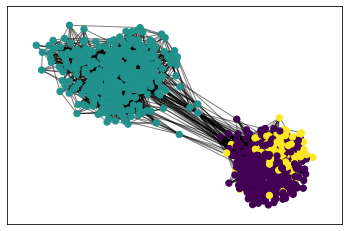

{'ThetThetZaw9': 0, 'bernamadotcom': 1, 'BukanPengkhian1': 1, 'TDH20603555': 2, 'LeeDam_3': 2, 'Hana_Poeei': 0, 'wafeeqahhh': 1, 'htarhtarmedlar': 2, 'Imsexyandiknwt': 1, 'phayhtone': 0, 'historyogi': 1, 'pedoqpop': 1, 'poppymcp': 0, 'YahooSG': 1, 'ThuraMaung5249': 2, 'Dragon56454849': 0, 'HtinAun07527764': 0, 'MayKhin16914875': 0, 'NadiaDaeng': 1, 'Thida58432345': 2, 'HninZar3': 0, 'Htethte41756250': 0, 'syeebae': 1, 'DoublePPK': 0, 'SAdamsR2P': 0, 'Snow28122015': 2, 'kshonnvix': 0, 'k_nana0813': 0, 'ZengLoungLoung': 0, 'afimahiro': 1, 'sudhirtv': 1, '__mnamin': 1, 'khaing_ei': 0, 'ABayyy9': 0, 'MichelleYesudas': 1, 'Muhaaiimin': 1, 'mm93564973': 0, 'exo_mess': 0, 'sarahcoldheart': 1, 'hidzdotfm': 1, 'walone4': 0, 'sarahrxdriguez': 1, 'Julia17550969': 0, 'steelbiimu_': 1, 'leehsienloong': 1, 'SonEGoldenstar4': 2, 'theintthan2000': 0, 'ThaimtThaimt': 0, 'val80387638': 0, 'Phu_twt_mm': 0, 'tuesdayswavery': 1, 'NewsPamphlet': 0, 'DeputySecState': 0, 'lcsmxms': 1, 'ShweSinTun99': 2, 'Shoo

<Figure size 432x288 with 0 Axes>

In [73]:
communities_plot_save_path = DATA_PATH + "output/networking/clusters"
communities_save_path = DATA_PATH + "output/networking/clusters.json"
user_to_community_save_path = DATA_PATH + "output/networking/user_to_cluster.json"

communities_grouped = get_communities(G_pruned, communities_save_path, communities_plot_save_path, user_to_community_save_path)

In [74]:


G_pruned = remove_low_degree_edges(G, 40)
get_graph_details(G_pruned)


low_degree_nodes = [node for node, degree in dict(G_pruned.degree()).items() if degree == 0]
print("Number of users to be removed with degree less than {}: {}".format( 0, len(low_degree_nodes)))
G_pruned.remove_nodes_from(low_degree_nodes)

print("*"*10)
get_min_graph_degree(G_pruned)
# 

Number of users to be removed with degree less than 40: 47216
New graph: 18834 2244
The maximum degree of the graph is 341
The minimum degree of the graph is 0
There are 2244 nodes and 18834 edges present in the graph
The average degree of the nodes in the graph is 16.78609625668449
Number of users to be removed with degree less than 0: 102
**********
The minimum degree of the graph is 1


1

In [ ]:
G_pruned_pos = nx.spring_layout(G_pruned)

In [ ]:
communities_plot['LyaHaru']

In [ ]:
cyto_data = []

In [ ]:
for node in G_pruned.nodes:
    node_data = {'data': {'id': node, 'label': node}, 'position': {'x': G_pruned_pos[node][0], 'y': G_pruned_pos[node][1]}}
    cyto_data.append(node_data)

In [79]:
# [print(x) for x in cyto_data] 
tweets.columns

Index(['Unnamed: 0', 'tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quo

In [85]:
tweets[tweets['user_id_x', 'user_verified']].unique()

KeyError: ('user_id_x', 'user_verified')